In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

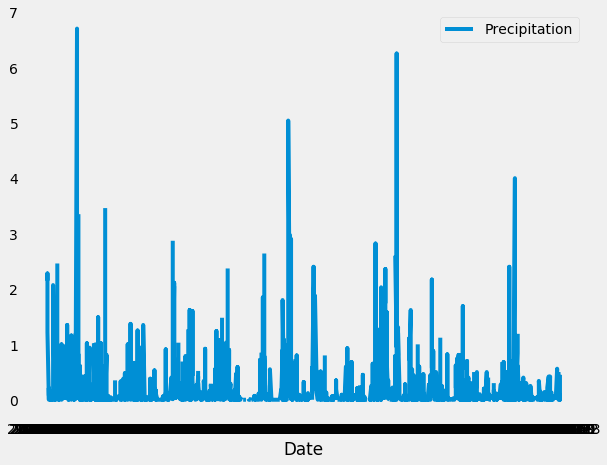

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
one_year_ago = dt.datetime.strptime(last_date[0],"%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
measurements = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date > one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_precip = pd.DataFrame(measurements, columns = ["Date", "Precipitation"])
df_precip.set_index('Date', inplace=True)

# Sort the dataframe by date
df_precip_sorted = df_precip.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(df_precip_sorted, label = 'Precipitation')
ax.set(xlabel='Date')
ax.grid()
ax.legend()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_precip_sorted.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
print(f"Number of stations in the dataset: {session.query(Station.id).count()}")

Number of stations in the dataset: 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

print("Station", "\t", "Count")
print("-----------------------")
for station, count in station_activity:
    print(station, "\t", count)

Station 	 Count
-----------------------
USC00519281 	 2772
USC00519397 	 2724
USC00513117 	 2709
USC00519523 	 2669
USC00516128 	 2612
USC00514830 	 2202
USC00511918 	 1979
USC00517948 	 1372
USC00518838 	 511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == "USC00519281").first()
print(f'''
----------------------
Recorded Temeperatures
----------------------
Lowest: {station_stats[0]}
Highest: {station_stats[1]}
Average: {round(station_stats[2],2)}
''')


----------------------
Recorded Temeperatures
----------------------
Lowest: 54.0
Highest: 85.0
Average: 71.66



Station with highest # of Temperature observations: USC00519397


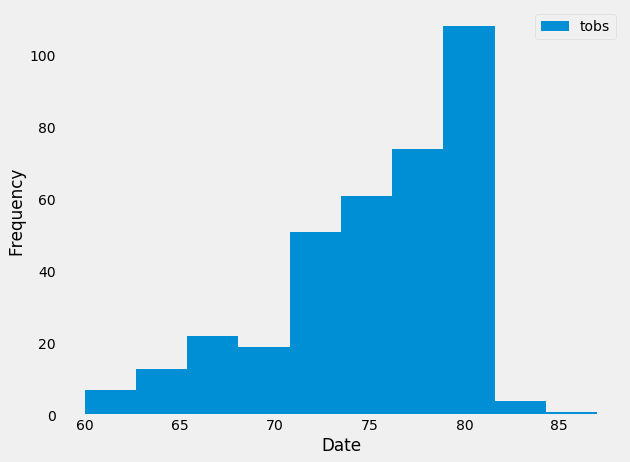

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp = session.query(Measurement.station, func.count(Measurement.tobs)).\
                order_by(func.count(Measurement.tobs).desc()).first()
print(f"Station with highest # of Temperature observations: {station_temp[0]}")

station_hist = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.date > one_year_ago).\
                filter(Measurement.station == station_temp[0]).all()

df_temp = pd.DataFrame(station_hist, columns = ["Date", "Temperature"])
df_temp.set_index('Date', inplace=True)
fig, ax = plt.subplots(figsize=(9,7))
ax.hist(df_temp['Temperature'], label='tobs')
ax.set(xlabel='Date',ylabel='Frequency')
ax.grid()
ax.legend()
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

latest_date = dt.datetime.strptime(last_date[0],"%Y-%m-%d")
my_trip = calc_temps(one_year_ago, latest_date)
print(my_trip)

[(58.0, 74.57894736842105, 87.0)]


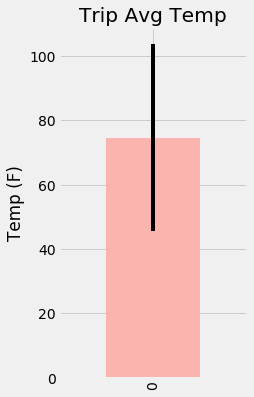

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df_trip = pd.DataFrame(my_trip, columns=['tmin', 'tavg', 'tmax'])

yerror = df_trip['tmax'] - df_trip['tmin']
avg_temp = df_trip['tavg']

fig, ax = plt.subplots(figsize=(3,6))
ax = avg_temp.plot(kind='bar', grid=True, yerr=yerror, colormap='Pastel1')
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp (F)')
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_rain = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        join(Measurement, Station.station == Measurement.station).\
        filter(Measurement.date >= one_year_ago).filter(Measurement.date <= latest_date).\
        group_by(Station.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

print("-----------------------------------------------------------------------------------------------------------")
print("Station", "\t", "Name", "\t\t\t", "Latitude", "\t", "Longitude", "\t", "Elevation", "\t", "Total Rainfall")
print("-----------------------------------------------------------------------------------------------------------")
for station, name, latitude, longitude, elevation, rainfall in station_rain:
    if len(name) > 20:
        name = name[:17] + "..."
    print(station, "\t", name, "\t", round(latitude,2), "\t\t", round(longitude,2), "\t", elevation, "\t\t", round(rainfall,2))

-----------------------------------------------------------------------------------------------------------
Station 	 Name 			 Latitude 	 Longitude 	 Elevation 	 Total Rainfall
-----------------------------------------------------------------------------------------------------------
USC00516128 	 MANOA LYON ARBO 7... 	 21.33 		 -157.8 	 152.4 		 147.11
USC00519281 	 WAIHEE 837.5, HI US 	 21.45 		 -157.85 	 32.9 		 68.24
USC00513117 	 KANEOHE 838.1, HI US 	 21.42 		 -157.8 	 14.6 		 48.36
USC00519523 	 WAIMANALO EXPERIM... 	 21.34 		 -157.71 	 19.5 		 37.99
USC00514830 	 KUALOA RANCH HEAD... 	 21.52 		 -157.84 	 7.0 		 33.19
USC00519397 	 WAIKIKI 717.2, HI US 	 21.27 		 -157.82 	 3.0 		 16.09
USC00517948 	 PEARL CITY, HI US 	 21.39 		 -157.98 	 11.9 		 4.59


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
